In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy.ndimage import median_filter
from scipy.stats import linregress
import pandas as pd
from ipywidgets import interact, IntSlider
import glob

In [2]:

mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams["font.family"] = "Serif"
# # plt.rcParams["font.serif"] = "TIMES"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times"] + plt.rcParams["font.serif"]
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'Serif'
mpl.rcParams['mathtext.it'] = 'Serif'
mpl.rcParams['mathtext.bf'] = 'Serif'
mpl.rcParams['text.usetex']= False
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

/localscratch/pbs.68039.hpc-clm-prd-t1/ipykernel_2800899/2312320211.py:13: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [3]:
def get_data(logs_dir):
    freqs = []
    profs = []
    n_profs = []
    # prof_index = pd.read_table(f"{logs_dir}/profiles.index", skiprows=1, sep='\s+')
    prof_index = np.loadtxt(f"{logs_dir}/profiles.index", skiprows=1, dtype=int)

    for f in sorted(glob.glob(f"{logs_dir}/profile*.data.GYRE"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1])):
        profs.append(pd.read_table(f, skiprows=5, sep='\s+'))

    for f in sorted(glob.glob(f"{logs_dir}/profile*-freqs.dat"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1].split('-')[0])):
        freqs.append(pd.read_table(f, skiprows=5, sep='\s+'))
        n_profs.append(int(f.split('profile')[-1].split('-')[0]))
    hist = pd.read_table(glob.glob(f"{logs_dir}/history.data")[0], skiprows=5, sep='\s+')

    return hist, freqs, profs, n_profs, prof_index

# hist, freqs, profs, n_profs, prof_index = get_data("tests_here/test_M1.5_Z0.01/LOGS")
# n_profs

In [4]:
def fit_radial(ts, degree=0):
    """
    Fits a straight line to the radial mode frequencies. Optionally, can be used on non-radial modes.
    Only modes with radial orders 5-9 are used, as the ridges should be vertical here.
    
    Input: Theoretical (or observed) spectrum in pandas df format; mode degree to be used (default 0 = radial)
    Output: The length of the series used, and the slope, intercept, r_value, p_value, and std_err of the line.
    """
    n_min, n_max = 5, 9
    try:
        vert_freqs = ts.query("n_g == 0").query(f"l=={degree}").query(f"n_pg>={n_min}").query(f"n_pg<={n_max}")[["n_pg","Re(freq)"]].values
    except:
        vert_freqs = ts.query(f"l_obs=={degree}").query(f"n_obs>={n_min}").query(f"n_obs<={n_max}")[["n_obs","f_obs"]].values
    if len(vert_freqs>0):
        slope, intercept, r_value, p_value, std_err = linregress(vert_freqs[:,0], vert_freqs[:,1])
    else:
        slope, intercept, r_value, p_value, std_err = np.zeros(5)
    return len(vert_freqs), slope, intercept, r_value, p_value, std_err

def model_epsilon(ts):
    """
    Calls the fit_radial function to determine the epsilon value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Epsilon
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    eps = intercept/slope
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_dip > length_rad:
            eps = intercept/slope - 0.5 # take the ell=1 values and subtract 0.5 to equal epsilon (ell=0)
    return np.round(eps, 3)

def model_Dnu(ts):
    """
    Calls the fit_radial function to determine the Delta nu value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Delta nu
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_rad > length_dip:
            # redo radial
            length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    Dnu = slope
    return np.round(Dnu, 3)

def get_fit(l, freq):
    Dnu = model_Dnu(freq)
    epsilon = model_epsilon(freq)
    return Dnu, epsilon

In [5]:
def comp_plot(logs_dirs, plot_type="age_eps", subplot=False):
    if not subplot:
        fig = plt.figure(figsize=(10, 6))
    Z_in = [0.010, 0.012, 0.014, 0.016, 0.018, 0.020, 0.022]
    palette = sns.color_palette("flare", n_colors=len(Z_in))
    sns.set_palette(palette)
    cmap = mpl.colors.ListedColormap(palette)
    for logs_dir in logs_dirs:
        M = logs_dir.split('/')[-2].split('_')[-2].split('M')[-1]
        Z = logs_dir.split('/')[-2].split('_')[-1].split('Z')[-1]
        hist, freqs, profs, n_profs, prof_index = get_data(logs_dir)
        models = [i[0] for i in prof_index if i[2] in n_profs]
        eps = []
        age = []
        dnu = []
        for i in range(len(freqs)):
            Dnu, epsilon = get_fit(0, freqs[i])
            eps.append(epsilon)
            age.append(hist[hist.model_number == models[i]]['star_age']/1e6)
            dnu.append(Dnu)
        if plot_type == "age_eps":
            # ax.scatter(age, eps, s=10, label=f'M = {M}, Z = {Z}')
            plt.plot(age, eps, label=f'M = {M}, Z = {Z}')
            plt.xlabel('Age (Myr)')
            plt.ylabel('Epsilon')
            plt.title('Epsilon vs Age')
        elif plot_type == "dnu_eps":
            # ax.scatter(dnu, eps, s=10, label=f'M = {M}, Z = {Z}')
            plt.plot(dnu, eps, label=f'M = {M}, Z = {Z}')
            plt.xlabel('Dnu')
            plt.ylabel('Epsilon')
            plt.title('Epsilon vs Dnu')
        elif plot_type == "age_dnu":
            # ax.scatter(age, Dnu, s=10, label=f'M = {M}, Z = {Z}')
            plt.plot(age, dnu, label=f'M = {M}, Z = {Z}')
            plt.xlabel('Age (Myr)')
            plt.ylabel('Dnu')
            plt.title('Dnu vs Age')
    z = [[0,0],[0,0]]
    levels = Z_in
    contour = plt.contourf(z, levels, cmap=cmap)
    plt.colorbar(contour, ticks=Z_in, 
                    boundaries=np.arange(len(Z_in)+1)-0.5, label=r'$Z_{in}$')
    

logs_dirs = sorted(glob.glob(f"tests_here/test_M*/LOGS"), key=lambda x: float(x.split('/')[-2].split('_')[-1].split('Z')[-1]))
# logs_dirs = ["tests_here/test_M1.5_Z0.01/LOGS"]

# comp_plot(logs_dirs, plot_type="age_eps")
# plt.xlim(6, 20)
# plt.ylim(1.4, 2)
# comp_plot(logs_dirs, plot_type="age_dnu")
# comp_plot(logs_dirs, plot_type="dnu_eps")

In [6]:
def comp_plot_nuc(logs_dirs, plot_type="pp", subplot=False):
    if not subplot:
        fig = plt.figure(figsize=(10, 6))
    Z_in = [0.010, 0.012, 0.014, 0.016, 0.018, 0.020, 0.022]
    palette = sns.color_palette("flare", n_colors=len(Z_in))
    sns.set_palette(palette)
    cmap = mpl.colors.ListedColormap(palette)
    for logs_dir in logs_dirs:
        M = logs_dir.split('/')[-2].split('_')[-2].split('M')[-1]
        Z = logs_dir.split('/')[-2].split('_')[-1].split('Z')[-1]
        hist, freqs, profs, n_profs, prof_index = get_data(logs_dir)
        models = [i[0] for i in prof_index if i[2] in n_profs]
        age = []
        pp = []
        cno = []
        for i in range(len(freqs)):
            age.append(hist[hist.model_number == models[i]]['star_age']/1e6)
            pp.append(hist[hist.model_number == models[i]]['pp'].values[0])
            cno.append(hist[hist.model_number == models[i]]['cno'].values[0])
        if plot_type == "pp":
            plt.plot(age, 10**np.array(pp), label=f'M = {M}, Z = {Z}')
            plt.xlabel('Age (Myr)')
            plt.ylabel(r'$\frac{L_{pp}}{L_{\odot}}$')
            plt.title('L_pp vs Age')
        elif plot_type == "cno":
            plt.plot(age, 10**np.array(cno), label=f'M = {M}, Z = {Z}')
            plt.xlabel('Age (Myr)')
            plt.ylabel(r'$\frac{L_{cno}}{L_{\odot}}$', fontsize=15)
            plt.title(r'$L_{cno}$ vs Age')
    z = [[0,0],[0,0]]
    levels = Z_in
    contour = plt.contourf(z, levels, cmap=cmap)
    plt.colorbar(contour, ticks=Z_in, 
                    boundaries=np.arange(len(Z_in)+1)-0.5, label=r'$Z_{in}$')
    
# logs_dirs = ["tests_here/test_M1.5_Z0.01/LOGS"]

# comp_plot_nuc(logs_dirs, plot_type="pp")
# comp_plot_nuc(logs_dirs, plot_type="cno")
# plt.xlim(6, 25)

Comparison Plot

In [9]:
logs_dirs = sorted(glob.glob(f"test/m1.4_z0.002_v0_*/LOGS"))
logs_dirs

['test/m1.4_z0.002_v0_netbasic/LOGS',
 'test/m1.4_z0.002_v0_netcno_extras/LOGS',
 'test/m1.4_z0.002_v0_nethot_cno/LOGS',
 'test/m1.4_z0.002_v0_netpp_and_cno_extras/LOGS',
 'test/m1.4_z0.002_v0_netpp_extras/LOGS']

In [79]:
palette = sns.color_palette("flare", n_colors=len(Z_in))
sns.set_palette(palette)
cmap = mpl.colors.ListedColormap(palette)
age = []
cno = []
eps = []
dnu = []
density = []
for logs_dir in logs_dirs:
    M = logs_dir.split('/')[-2].split('_')[-2].split('M')[-1]
    Z = logs_dir.split('/')[-2].split('_')[-1].split('Z')[-1]
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dir)
    models = [i[0] for i in prof_index if i[2] in n_profs]
    age_i = []
    cno_i = []
    eps_i = []
    dnu_i = []
    density_i = []
    for i in range(len(freqs)):
        Dnu, epsilon = get_fit(0, freqs[i])
        eps_i.append(epsilon)
        age_i.append(hist[hist.model_number == models[i]]['star_age']/1e6)
        dnu_i.append(Dnu)
        cno_i.append(hist[hist.model_number == models[i]]['cno'].values[0])
        density_i.append(hist[hist.model_number == models[i]]['log_cntr_Rho'].values[0])
    age.append(age_i)
    cno.append(cno_i)
    eps.append(eps_i)
    dnu.append(dnu_i)
    density.append(density_i)


In [74]:
print(len(age), len(dnu), len(cno), len(density))

7 7 7 7


1.2 0.002
1.2 0.006
1.2 0.01
1.2 0.014
1.2 0.018
1.2 0.022
1.2 0.026


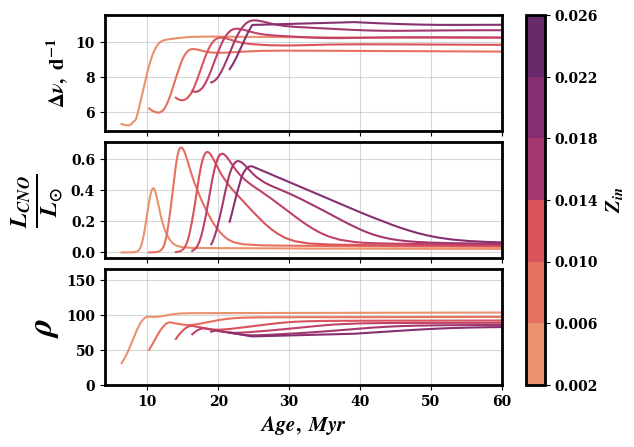

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=1)
ax1 = axes[0]
ax2 = axes[1] 
ax3 = axes[2]

i = 0
for log in logs_dirs:
    M = log.split('/')[-2].split('_')[-2].split('M')[-1]
    Z = log.split('/')[-2].split('_')[-1].split('Z')[-1]
    print(M, Z)
    ax1.plot(age[i], dnu[i], color=palette[i])
    ax2.plot(age[i], 10**np.array(cno[i]), color=palette[i])
    ax3.plot(age[i], 10**np.array(density[i]), color=palette[i])
    i += 1
ax1.set_ylabel(r'$\Delta\nu,\ \rm{d}^{-1}$', fontsize=15)
ax2.set_ylabel(r'$\frac{L_{CNO}}{L_{\odot}}$', fontsize=25)
ax3.set_ylabel(r'$\rho}$', fontsize=25)
plt.xlabel(r'$Age,\ Myr$', fontsize=15)
ax1.set_xlim(4, 60)
ax2.set_xlim(4, 60)
ax3.set_xlim(4, 60)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
plt.subplots_adjust(wspace=0, hspace=0.1)
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax3.grid(alpha=0.5)
z = [[0,0],[0,0]]
levels = Z_in
contour = plt.contourf(z, levels, cmap=cmap)
cb = fig.colorbar(contour, ticks=Z_in, 
                boundaries=np.arange(len(Z_in)+1)-0.5, ax=axes.ravel().tolist())
cb.set_label(label=r'$Z_{in}$', size=15, weight='bold')
plt.show()

In [10]:
age = []
cno = []
eps = []
dnu = []
density = []
for logs_dir in logs_dirs:
    net = logs_dir.split('/')[-2].split('_')[-3]
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dir)
    models = [i[0] for i in prof_index if i[2] in n_profs]
    age_i = []
    cno_i = []
    eps_i = []
    dnu_i = []
    density_i = []
    for i in range(len(freqs)):
        Dnu, epsilon = get_fit(0, freqs[i])
        eps_i.append(epsilon)
        age_i.append(hist[hist.model_number == models[i]]['star_age']/1e6)
        dnu_i.append(Dnu)
        cno_i.append(hist[hist.model_number == models[i]]['cno'].values[0])
        density_i.append(hist[hist.model_number == models[i]]['log_cntr_Rho'].values[0])
    age.append(age_i)
    cno.append(cno_i)
    eps.append(eps_i)
    dnu.append(dnu_i)
    density.append(density_i)


KeyboardInterrupt: 

In [ ]:
net